# __Stock market price prediction and risk analysis using Geometric Browninan Motion__

#### Aloken Chaudhari

#### Import dependencies

In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Plot Apple's Stock over the course of a year 

Display how the graph changes when displaying Open price, Close price, High price, and Low Price for each day.
<br>
Also display volume of stocks traded per day

In [55]:
apple = yf.Ticker("AAPL")

today = datetime.now()

start_date = today - timedelta(days=365)

hist = apple.history(start = start_date, end = today)

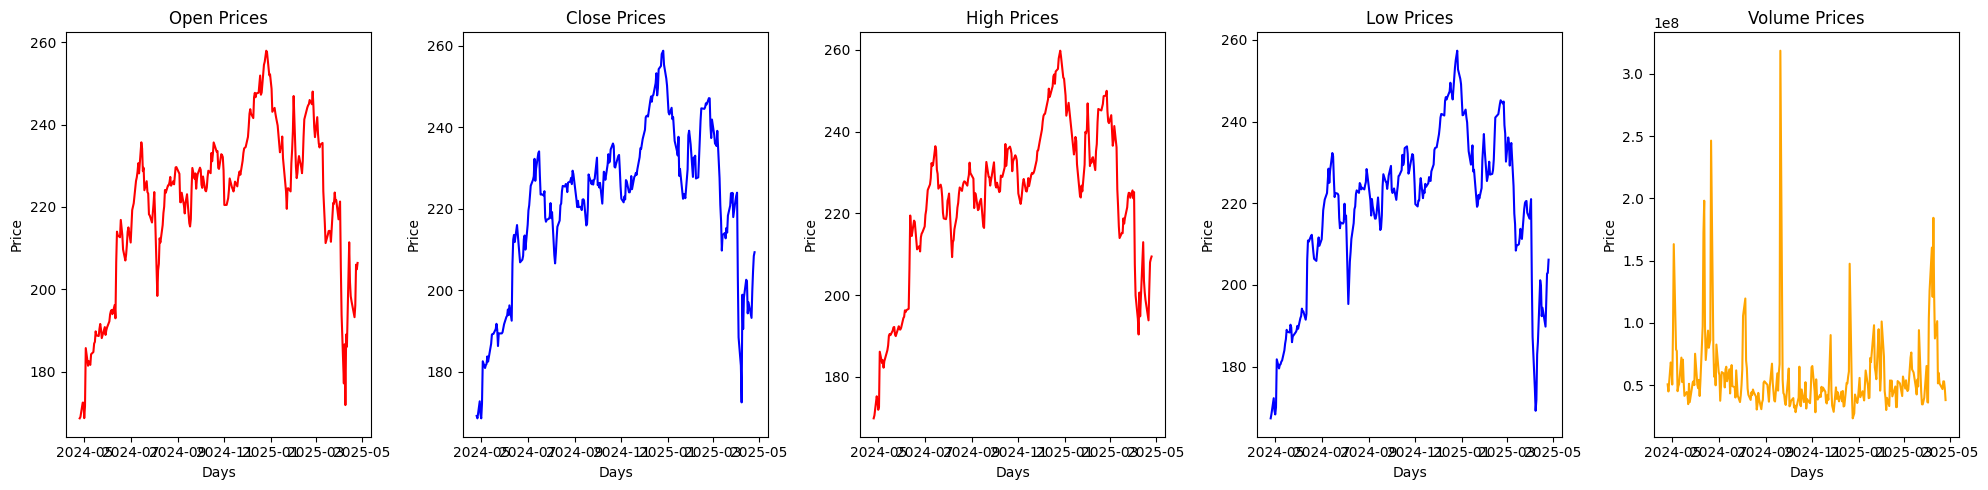

In [ ]:
y1 = hist['Open']
y2 = hist['Close']
y3 = hist['High']
y4 = hist['Low']
y5 = hist['Volume']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].plot(y1, label='Open', color='red')
axes[0].set_title('Open Prices')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Price')

axes[1].plot(y2, label='Close', color='blue')
axes[1].set_title('Close Prices')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Price')

axes[2].plot(y3, label='High', color='red')
axes[2].set_title('High Prices')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Price')

axes[3].plot(y4, label='Low', color='blue')
axes[3].set_title('Low Prices')
axes[3].set_xlabel('Days')
axes[3].set_ylabel('Price')

axes[4].plot(y5, label='Volume', color='orange')
axes[4].set_title('Volume')
axes[4].set_xlabel('Days')
axes[4].set_ylabel('Price')

plt.tight_layout()
plt.show()


In [57]:
multi_data = yf.download(['AAPL', 'MSFT', 'AMZN'], start = start_date, end = today, auto_adjust=True)

[*********************100%***********************]  3 of 3 completed


Text(0.5, 1.0, 'Stock Prices of AAPL, MSFT, and AMZN')

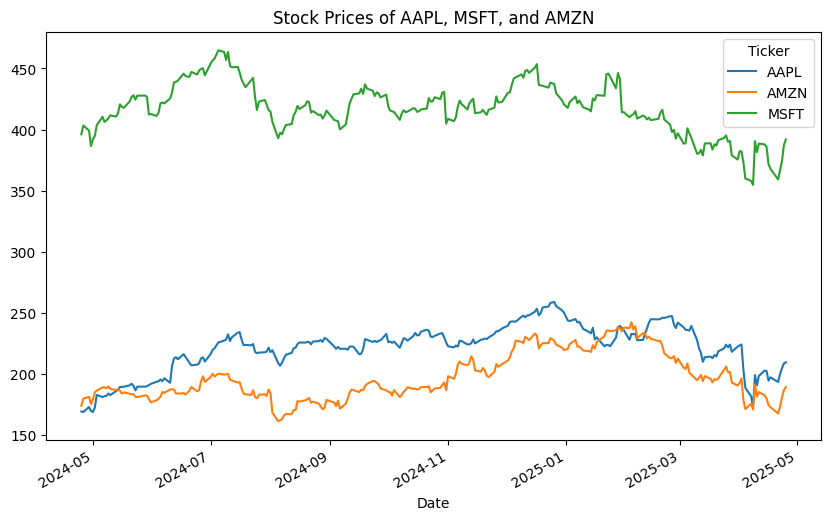

In [103]:
multi_data['Close'].plot(figsize=(10, 6))
plt.title('Stock Prices of AAPL, MSFT, and AMZN')

## __Geometric Brownian Motion__

Geometric Brownian Motion is a stochastic differential equation which can be used to model stock prices. 

__The equation for price modelling is:__ 

$$ d S_t = \mu S_t dt + \sigma S_t d W_t $$

Where:

- $S_t$ is stock price at time $t$

- $\mu$ is expected return (drift)
    - Drift represents the average rate of return of a stock over time

- $\sigma$ is volatility
    - How much a stock's price varies over time, where a high volatility represents extreme price swings
    
- $d W_t$ represents a Wiener process increment
    - Also known as Brownian motion.
    - This is used to add randomness to the model.
    - Adds randomness at every time step to create a random walk over time

__Discrete Approximation:__

$$ S_{t + \delta t} = S_t \cdot exp((\mu - \frac{1}{2} \sigma^{2}) \Delta t + \sigma \cdot \sqrt{\Delta t} \cdot Z) $$

Where : 

- $S_{t + \delta t}$ is the stock price at the next time step ($ t + \delta t $). This is the value being calculated.

- $S_t$ is the stock price at the current tim'$ t $. This serves as the starting point for the calculation.

- $\mu$ is the drift or expected return of the stock. It represents the average rate of return over time.

- $\sigma$ is the volatility of the stock, which measures the degree of price fluctuations. Higher volatility indicates larger price swings.

- $\Delta t$ is the time step for the simulation. It represents the small increment of time between $ t $ and $ t + \delta t $.

- $Z$ is a standard normal random variable ($ Z \sim N(0, 1) $). This introduces randomness into the model, simulating the unpredictable nature of stock price movements.

### Get Apple Stock Data

In [59]:
data = yf.download('AAPL', start = start_date, end = today, auto_adjust=True)
prices = data['Close']

[*********************100%***********************]  1 of 1 completed


### Calculate $\mu$ and $\sigma$

In [63]:
logged_returns  =np.log(prices / prices.shift(1)).dropna()
mu = logged_returns.mean().item()
sigma = logged_returns.std().item()

### Discrete Approximation

In [64]:
def simulate_gbm(S0, mu, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M,N))
    paths[:,0] = S0
    for t in range(1, N):
        Z = np.random.normal(0, 1, M)
        paths[:,t] = paths[:,t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

### GBM model simulated paths for Apple stock (100 simulations)

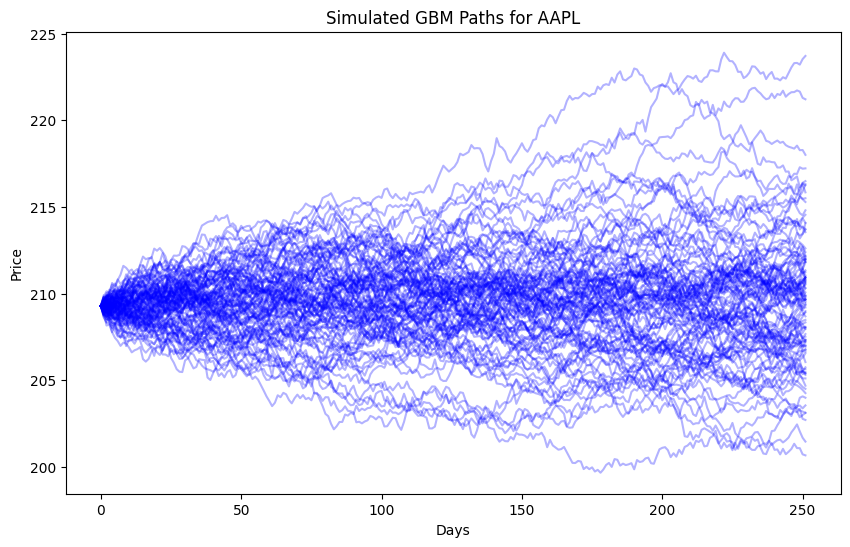

In [115]:
paths = simulate_gbm(S0=prices.iloc[-1], mu = mu, sigma = sigma, T=1, N=252, M=100)
plt.figure(figsize=(10, 6))
plt.plot(paths.T, color='blue', alpha=0.3)
plt.title('Simulated GBM Paths for AAPL')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

## Risk Estimation

### Step 1: Run 1000 GBM Simulations

In [80]:
paths = simulate_gbm(S0=prices.iloc[-1], mu = mu, sigma = sigma, T=1, N=252, M=1000)
final_prices = paths[:,-1]

### Expected Price

In [95]:
expected_price = final_prices.mean()
print(f"Expected Price: ${expected_price.round(2)}") 

Expected Price: $209.68


### Risk of negative return

In [98]:
risk_of_loss = np.mean(final_prices < prices.iloc[-1].item())
print(f"Risk of negative return: {(risk_of_loss * 100).round(2)} %")

Risk of negative return: 46.8 %


### Understanding range of possible outcomes using histograms

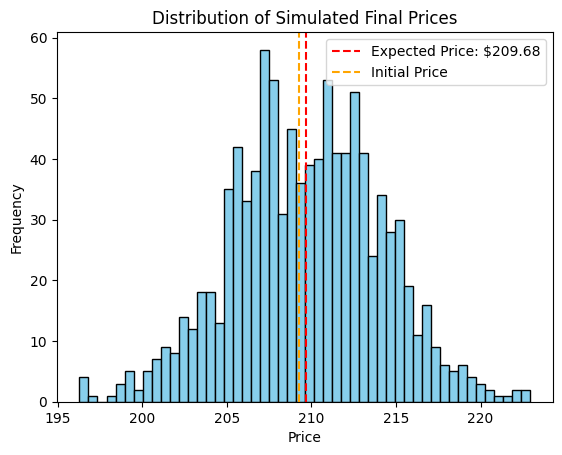

In [83]:
plt.hist(final_prices, bins=50, color='skyblue', edgecolor='black')
plt.axvline(expected_price, color='red', linestyle='--', label=f'Expected Price: ${expected_price:.2f}')
plt.axvline(prices.iloc[-1].item(), color='orange', linestyle='--', label='Initial Price')
plt.title("Distribution of Simulated Final Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Range of likely outcomes

In [84]:
lower, upper = np.percentile(final_prices, [2.5, 97.5])
print(f"95% confidence interval: ${lower:.2f} to ${upper:.2f}")

95% confidence interval: $200.77 to $218.21


## __Conclusions and Analysis:__

__GBM Assumptions__

- Constant drift ($\mu$) and volatility ($\sigma$) over time are assumed.
- It is assumed that Log returns are normally distributed → prices are log-normally distributed.
- Its assumed that there are no jumps or abrupt shocks.
- No arbitrage: the model assumes a fair market.

__Limitations__

- Real markets have sudden jumps (Ex. earnings surprises, geopolitical events).
- Volatility may change over time (Ex. during a financial crisis).
- GBM ignores interest rates, transaction costs, and liquidity.

### Compare Actual Prices to Simulation Values

In [ ]:
ticker = 'AAPL'
end_date = datetime.today()
start_date = end_date - timedelta(days=365)
actual_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

actual_final_price = actual_data['Close'].iloc[-1].item()
print(f"Actual final price after 1 year: ${actual_final_price:.2f}")

print(f"Predicted 95% CI: ${lower:.2f} to ${upper:.2f}")
if lower <= actual_final_price <= upper:
    print("✅ Actual price fell within the predicted range.")
else:
    print("❌ Actual price was outside the predicted range — possible model limitations.")

[*********************100%***********************]  1 of 1 completed

Actual final price after 1 year: $208.37
Predicted 95% CI: $200.77 to $218.21
✅ Actual😋 price fell within the predicted range.


## __Summary:__

The expected final price was $209.68, and our 95% confidence interval ranged from $200.77 to $218.21. The actual price was $208.37 after 1 year, which fell within the predicted range. The expected value was had a percent error of 0.629%. While this is a very accurate result. This is likely due to chance, as the model will underestimate events which are rare, but impactful. Market behavior is also more volatile than a constant sigma assumes.